In [1]:
import glob

import cv2
import matplotlib.pyplot as plt
import numpy as np
import imutils

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

from pathlib import Path

from torchvision.models import resnet18
import torchvision.transforms as transforms

import torch.optim as optim



# Model

In [2]:
class DigitClassifier(nn.Module):
    
    def __init__(self, n_cls=16, in_feat=28*28):
        super().__init__()
        
        resnet = resnet18()
        self.feature = nn.Sequential(*list(resnet.children())[:-3])
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.flatten = nn.Flatten()
        self.fc = nn.Sequential(
            nn.Linear(256, 512, bias=True),
            nn.Sigmoid(),
            nn.Linear(512, n_cls)
        )
        
    def forward(self, x):
        out = self.feature(x)
        out = self.avgpool(out)
        out = self.flatten(out)
        out = self.fc(out)
        return out

In [3]:
class SymbolsDataset(Dataset):
    
    def __init__(self, path2npdata: Path, transform=None):
        
        self.data = np.load(path2npdata, allow_pickle=True)
        self.data = self.data.copy()
        self.labels_dict = {'+': '10', '-': '11', '*': '12', '%': '13', '[': '14', ']': '15'}
        self.transform = transform
        self.images = self.data[:, 0]
        self.labels = self.data[:, 1]

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        
        img = (self.images[idx]).astype(np.float32)
        label = self.labels[idx]
        label = eval(self.labels_dict[label] if label in self.labels_dict else label)
        # img = img / 255.  # normalize image to range [0, 1]
        img = np.dstack((img, img, img))
        if self.transform:
            img = self.transform(img)
        return img, label

### Useful functions

In [50]:
def multi_plotter(arrs, predds=None, num=None):

    fig, ax = plt.subplots(1, len(arrs), figsize=(15, 10))
    for i, imgg in enumerate(arrs):
        ax[i].imshow(imgg)
        if predds:
            ax[i].set_title(f'Predicted: {predds[i]}')
    if num:
        plt.savefig('out'+num)
    plt.show()


def converter(arr):
    symbols = {10: '+', 11: '-', 12: '*', 13: '/', 14: '(', 15: ')'}
    for i, j in enumerate(arr):
        if j in symbols.keys():
            arr[i] = symbols[j]

    arr = list(map(str, arr))
    eq = ''.join(arr)
    return eq


def bbox_creator(imgg):

    blurred = cv2.GaussianBlur(imgg, (7, 7), 0)
    edged = cv2.Canny(blurred, 30, 150)
    contours = cv2.findContours(edged, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]

    # Create a copy of the original image to display the output rectangles
    output = imgg.copy()
    output = cv2.cvtColor(output, cv2.COLOR_GRAY2BGR)

    bounding_boxes_list = []
    # Loop through contours calculating the bounding rectangles and plotting them
    for c in contours:
        x, y, w, h = cv2.boundingRect(c)
        x1, y1 = x, y
        x2, y2 = x + w, y + h
        if w * h > 100:  # погрешность чекинг
            bounding_boxes_list.append([x1, y1, x2, y2])
            cv2.rectangle(output, (x,y), (x+w, y+h), (255, 55, 100), 5)

    return output, bounding_boxes_list   


def cropper_f1(imgg, bboxes_list, bb=None):
    cropps = []
    for bbox in bboxes_list:
        x1, y1, x2, y2 = bbox
        cropp = imgg[y1:y2, x1:x2]
        
        cropp =imutils.resize(cropp, height=28, width=28, inter=cv2.INTER_AREA)

        # для правильного решэйпа
        max_n = max(cropp.shape)
        new_h, new_w = cropp.shape
        h1 = int((max_n-new_h)/2)
        h2 = max_n-new_h - h1
        w1 = int((max_n-new_w)/2)
        w2 = max_n-new_w - w1
        cropp = np.pad(cropp, ((h1, h2), (w1, w2)), mode='constant', constant_values=0)
        cropp=imutils.resize(cropp, height=28, width=28, inter=cv2.INTER_AREA)
        cropp = (cropp > 1).astype(float)
        cropps.append(cropp)

    # sort crops по координате X
    crops_coords = list(zip(cropps, bboxes_list))
    sorted_crops = sorted(crops_coords, key=lambda x: x[1][0])


    sorted_crops_f = [sorted_crops[0][0]]
    lenght = len(sorted_crops)
    for i in range(1, lenght):
        if sorted_crops[i][1][2] >= sorted_crops[i-1][1][2]:
            sorted_crops_f.append(sorted_crops[i][0])
    return sorted_crops_f


def load_model(net, path2pth: str, device=torch.device("cpu")):
    state_dict = torch.load(path2pth, map_location=device)
    net.load_state_dict(state_dict)
    return net

## Train and Test data loading

In [5]:
path2train = r"CompleteDataSet_training_tuples.npy"
path2test = r"CompleteDataSet_testing_tuples.npy"

## Training

In [6]:
transform = transforms.Compose([transforms.ToTensor()])

batch_size = 256

trainset = SymbolsDataset(path2train, transform=transform)
testset = SymbolsDataset(path2test, transform=transform)

trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=0)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=0)

In [7]:
net = DigitClassifier(n_cls=16)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

net = net.to(device)
net = net.train()

In [12]:
# train loop

for epoch in range(10):
    break  # uncomment when needed
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        
        # labels = labels.type(torch.LongTensor)   # casting to long
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()

        
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()

    print(f'[{epoch + 1}] loss: {running_loss}')
    

print('Finished Training')

path2save = "./model.pth"
torch.save(net.state_dict(), path2save)
print(f"Model saved to: {Path(path2save.absolute())}")

[1] loss: 1715.1062915325165
[2] loss: 650.0417755842209
[3] loss: 273.7460168302059
[4] loss: 166.89165088534355
[5] loss: 124.50347953289747
[6] loss: 101.90878967940807
[7] loss: 86.44276627898216
[8] loss: 75.75894201919436
[9] loss: 67.40757062658668
[10] loss: 60.68202742934227
Finished Training


In [8]:
net = load_model(net, "model.pth", device=device)

In [9]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 97 %


## Test on real images

In [20]:
# function for load the tests

def tester(net, test_img, crops):
    net.to(device)
    net.eval()
    predicted_list = []
    with torch.no_grad():
        for img in crops:
            img = img.astype(np.float32)
            t_img = np.stack((test_img, test_img, test_img))
            t_img = torch.from_numpy(t_img).unsqueeze(0)
            
            out = net(t_img.to(device))

            _, predicted = torch.max(out.data, 1)
            predicted_list.append(predicted.cpu().numpy()[0])
    return predicted_list

### Step-by-step test

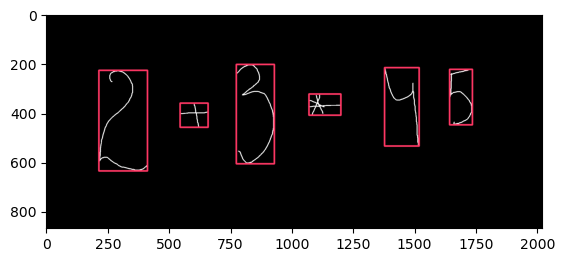

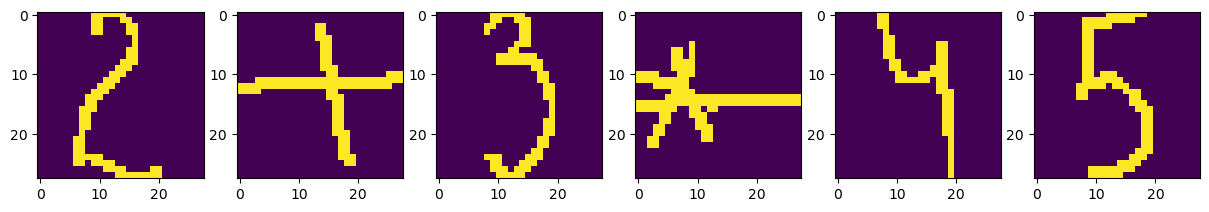

In [54]:
# test 1
test_1 = cv2.imread('tests/test_3.png', 0)
test_1 = 255 - test_1

output_bb_1, bboxes_1 = bbox_creator(test_1)
plt.imshow(output_bb_1, cmap='gray')
plt.show()
crops_1 = cropper_f1(test_1, bboxes_1)
multi_plotter(crops_1)
plt.show()

----

Not always bboxes are recognized well. Sometimes there are overlaps. But the algo which filters this overlaps is located in cropper (func), thats why in this step you can only see not final version of bboxes, but they are filterred in the next step.

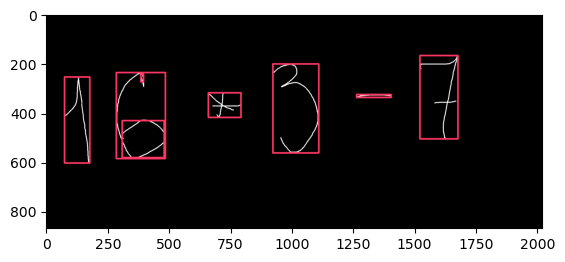

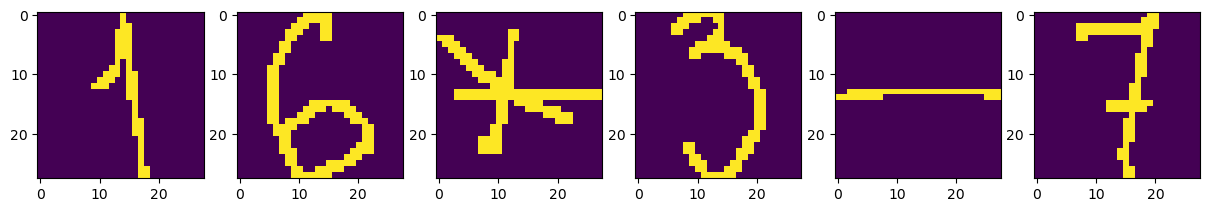

In [53]:
# test bad bboxes
test_b = cv2.imread('tests/test_2.png', 0)
test_b = 255 - test_b

output_bb_b, bboxes_b = bbox_creator(test_b)
plt.imshow(output_bb_b, cmap='gray')
plt.show()
crops_b = cropper_f1(test_b, bboxes_b)
multi_plotter(crops_b)
plt.show()

----

In [55]:
net.to(device)
net.eval()
predicted_list = []
with torch.no_grad():
    for img in crops_1:
        img = img.astype(np.float32)
        t_img = np.stack((img, img, img))
        t_img = torch.from_numpy(t_img).unsqueeze(0)
        
        out = net(t_img.to(device))

        _, predicted = torch.max(out.data, 1)
        predicted_list.append(predicted.cpu().numpy()[0])

predicts = converter(predicted_list)

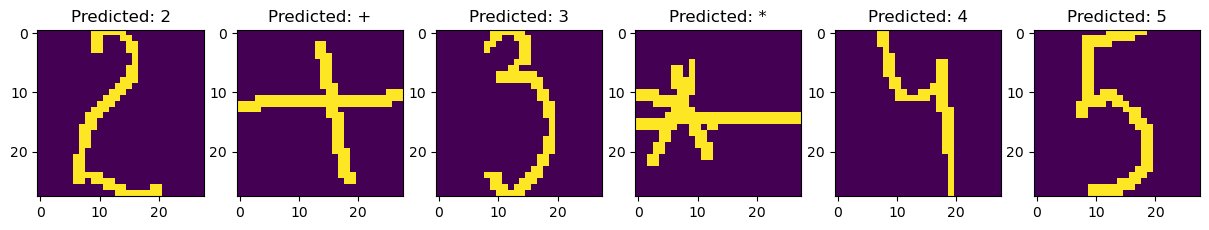

In [56]:
multi_plotter(crops_1, predds=predicts)

In [58]:
print(f'{predicts}={eval(predicts)}')

2+3*45=137


# Thats all. Thank you :)